# Model free analysis in the Aging project

1. In this notebook I will look at catch trial fails <br>
2. Age effect on proportion <br>
    2.1 age effect on proportion in risky trials <br>
    2.2 age effect on proportion in ambiguous trials <br>
3. cross domain correlations <br> 
4. consistency 

## Load libraries 

In [1]:
import pandas as pd
import numpy as np
import scipy as sp

import pymc as pm
import arviz as az

import matplotlib
import seaborn as sns

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
db_mon = pd.read_csv('data/mon_clean.csv')
db_med = pd.read_csv('data/med_clean.csv')

print('Participants monetary: ', len(db_mon['sub'].unique()), '\nparticipants medical: ', len(db_med['sub'].unique()))

Participants monetary:  66 
participants medical:  66


In [3]:
mon_risk_prop = db_mon[(db_mon.choice == 1) & (db_mon.ambiguity == 0)].groupby('sub').count()['choice']/db_mon[(db_mon.ambiguity == 0)].groupby('sub').count()['choice']
mon_ambg_prop = db_mon[(db_mon.choice == 1) & (db_mon.ambiguity >  0)].groupby('sub').count()['choice']/db_mon[(db_mon.ambiguity >  0)].groupby('sub').count()['choice']

med_risk_prop = db_med[(db_med.choice == 1) & (db_med.ambiguity == 0)].groupby('sub').count()['choice']/db_med[(db_med.ambiguity == 0)].groupby('sub').count()['choice']
med_ambg_prop = db_med[(db_med.choice == 1) & (db_med.ambiguity >  0)].groupby('sub').count()['choice']/db_med[(db_med.ambiguity >  0)].groupby('sub').count()['choice']

mon_risk_prop = mon_risk_prop.replace(np.nan, 0)
mon_ambg_prop = mon_ambg_prop.replace(np.nan, 0)
med_risk_prop = med_risk_prop.replace(np.nan, 0)
med_ambg_prop = med_ambg_prop.replace(np.nan, 0)

mon_risk_prop=mon_risk_prop.reset_index()
mon_ambg_prop=mon_ambg_prop.reset_index()
med_risk_prop=med_risk_prop.reset_index()
med_ambg_prop=med_ambg_prop.reset_index()

In [4]:
# get participants response at 0.5 risk and no ambiguity for ambiguity corrections
amb_correction_mon = db_mon[(db_mon['ambiguity'] == 0) & (db_mon['risk'] == 0.5)][['sub','value','choice']]
amb_correction_mon = amb_correction_mon.groupby(['sub','value']).mean()
amb_correction_mon.reset_index(inplace=True)

amb_correction_med = db_med[(db_med['ambiguity'] == 0) & (db_med['risk'] == 0.5)][['sub','value','choice']]
amb_correction_med = amb_correction_med.groupby(['sub','value']).mean()
amb_correction_med.reset_index(inplace=True)

In [5]:
mon_ambg_prop = mon_ambg_prop.merge(amb_correction_mon.groupby('sub').mean(), left_on='sub', right_on='sub')
med_ambg_prop = med_ambg_prop.merge(amb_correction_med.groupby('sub').mean(), left_on='sub', right_on='sub')

mon_ambg_prop['choice'] = mon_ambg_prop.choice_x-mon_ambg_prop.choice_y
med_ambg_prop['choice'] = med_ambg_prop.choice_x-med_ambg_prop.choice_y

In [6]:
proportion = mon_risk_prop.merge(med_risk_prop, left_on='sub', right_on='sub')

proportion = proportion.merge(mon_ambg_prop[['sub','choice']], left_on='sub', right_on='sub')
proportion = proportion.merge(med_ambg_prop[['sub','choice']], left_on='sub', right_on='sub')

proportion.columns = ['sub', 'MontaryRisk', 'MedicalRisk', 'MontaryAmb', 'MedicalAmb']
proportion = proportion.merge(db_mon[['sub','age']].drop_duplicates().reset_index(drop=True), left_on='sub', right_on='sub')

/tmp/ipykernel_967961/1853036382.py:4: FutureWarning: Passing 'suffixes' which cause duplicate columns {'choice_x'} in the result is deprecated and will raise a MergeError in a future version.
  proportion = proportion.merge(med_ambg_prop[['sub','choice']], left_on='sub', right_on='sub')


## Use robust regression to check an association between age and proportion

In [7]:
def corr(x, y):
    with pm.Model() as RR:

        a = pm.Normal('intercept', 0, 1)
        b = pm.Normal('slope', 0, 1)
        eps = pm.Exponential('eps', 1)
        y_hat = a + b*x

        nu = pm.InverseGamma("nu", alpha=3, beta=1)

        likelihood = pm.StudentT("likelihood", mu=y_hat, sigma=eps, nu=nu, observed=y)

        trace_robust = pm.sample()
        
    return(trace_robust)

In [8]:
risk_trace = corr(proportion.MontaryRisk, proportion.MedicalRisk)
ambg_trace = corr(proportion.MontaryAmb, proportion.MedicalAmb)

risk = az.summary(risk_trace, var_names=['slope','intercept'], hdi_prob=.89)[['mean','hdi_5.5%','hdi_94.5%']]
ambg = az.summary(ambg_trace, var_names=['slope','intercept'], hdi_prob=.89)[['mean','hdi_5.5%','hdi_94.5%']]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, eps, nu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, eps, nu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


In [9]:
mon_trace = corr(proportion.MontaryRisk, proportion.MontaryAmb)
med_trace = corr(proportion.MedicalRisk, proportion.MedicalAmb)

mon = az.summary(mon_trace, var_names=['slope','intercept'], hdi_prob=.89)[['mean','hdi_5.5%','hdi_94.5%']]
med = az.summary(med_trace, var_names=['slope','intercept'], hdi_prob=.89)[['mean','hdi_5.5%','hdi_94.5%']]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, eps, nu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
The acceptance probability does not match the target. It is 0.8933, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, eps, nu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


In [10]:
norm = matplotlib.colors.Normalize(vmin=18, vmax=90)
colors = {}
cmap = sns.diverging_palette(240, 10, as_cmap=True )

for cval in range(18,90):
    colors.update({cval : cmap(norm(cval))})
    

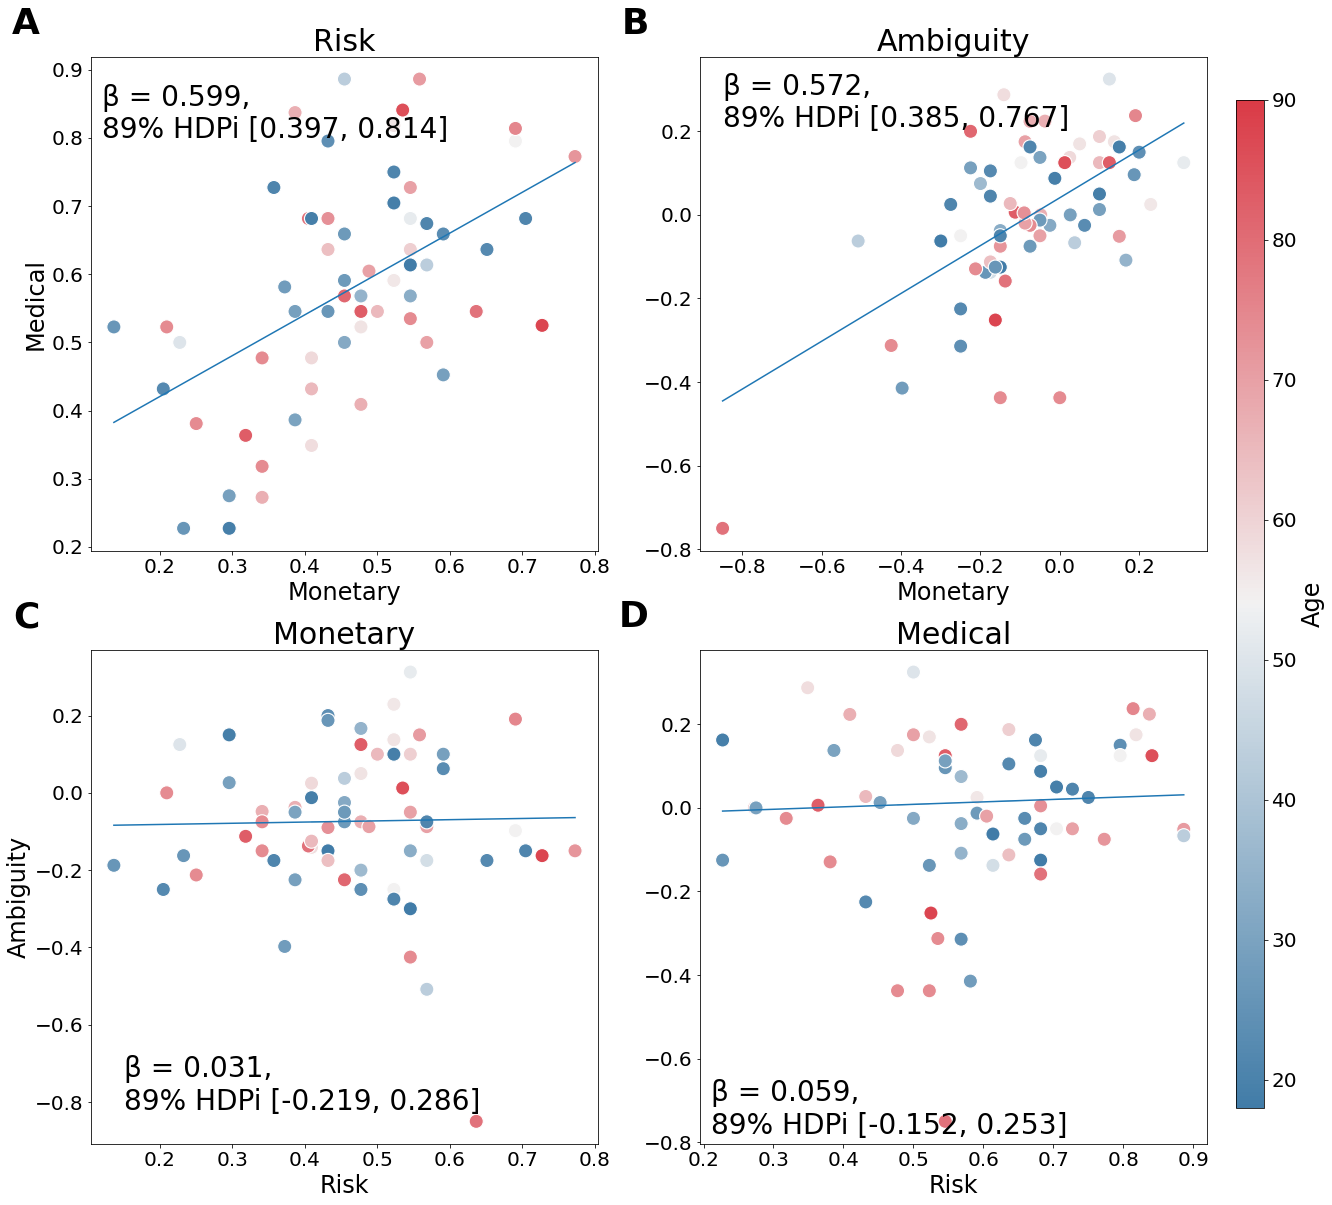

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(20, 20))
sns.scatterplot(x = 'MontaryRisk', y = 'MedicalRisk', data=proportion, ax=axes[0][0], s=200, hue = 'age', palette = colors)
sns.scatterplot(x = 'MontaryAmb',  y = 'MedicalAmb',  data=proportion, ax=axes[0][1], s=200, hue = 'age', palette = colors)

sns.scatterplot(x = 'MontaryRisk', y = 'MontaryAmb', data=proportion, ax=axes[1][0], s=200, hue = 'age', palette = colors)
sns.scatterplot(x = 'MedicalRisk', y = 'MedicalAmb', data=proportion, ax=axes[1][1], s=200, hue = 'age', palette = colors)

sns.lineplot(x = proportion.MontaryRisk, 
             y = risk['mean']['intercept']+risk['mean']['slope']*proportion.MontaryRisk, 
             ax=axes[0][0])
sns.lineplot(x = proportion.MontaryAmb,  
             y = ambg['mean']['intercept']+ambg['mean']['slope']*proportion.MontaryAmb, 
             ax=axes[0][1])

sns.lineplot(x = proportion.MontaryRisk, 
             y = mon['mean']['intercept']+mon['mean']['slope']*proportion.MontaryRisk, 
             ax=axes[1][0])
sns.lineplot(x = proportion.MedicalRisk, 
             y = med['mean']['intercept']+med['mean']['slope']*proportion.MedicalRisk, 
             ax=axes[1][1])




title = [['Risk','Ambiguity'],['Monetary','Medical']]
x_title = [['Monetary','Monetary'],['Risk','Risk']]
y_title = [['Medical',''],['Ambiguity','']]
subplot_labels = ['A', 'B', 'C', 'D']



text = 'β = {:.3f},\n89% HDPi [{:.3f}, {:.3f}]'.format(float(risk['mean']['slope']),
                                                        float(risk['hdi_5.5%']['slope']),
                                                        float(risk['hdi_94.5%']['slope']))
axes[0][0].text(.12, .8, text, fontsize=28)

text = 'β = {:.3f},\n89% HDPi [{:.3f}, {:.3f}]'.format(float(ambg['mean']['slope']),
                                                        float(ambg['hdi_5.5%']['slope']),
                                                        float(ambg['hdi_94.5%']['slope']))
axes[0][1].text(-.85, .21, text, fontsize=28)


text = 'β = {:.3f},\n89% HDPi [{:.3f}, {:.3f}]'.format(float(mon['mean']['slope']),
                                                        float(mon['hdi_5.5%']['slope']),
                                                        float(mon['hdi_94.5%']['slope']))
axes[1][0].text(.15, -.82, text, fontsize=28)

text = 'β = {:.3f},\n89% HDPi [{:.3f}, {:.3f}]'.format(float(med['mean']['slope']),
                                                        float(med['hdi_5.5%']['slope']),
                                                        float(med['hdi_94.5%']['slope']))
axes[1][1].text(.21, -.78, text, fontsize=28)

for i in range(2):
    for j in range(2):
        axes[i][j].legend_.remove()
        axes[i][j].tick_params(axis='both', labelsize=20)
        axes[i][j].set_title(title[i][j],size=30)
        axes[i][j].set_xlabel(x_title[i][j],size=24)
        axes[i][j].set_ylabel(y_title[i][j],size=24)


for ax, label in zip(axes.flat, subplot_labels):
    # Position the text at the top left of each subplot
    # Adjust x and y values to change the position of the label
    ax.text(-0.1, 1.1, label, transform=ax.transAxes, fontsize=36, fontweight='bold', va='top', ha='right')


# Create a new axes on the right side for the colorbar
position = fig.add_axes([0.92, 0.15, 0.02, 0.7]) # [left, bottom, width, height]
cb1 = matplotlib.colorbar.ColorbarBase(position, cmap=cmap,
                                       norm=norm,
                                       orientation='vertical')
cb1.set_label('Age', fontsize=24)
cb1.ax.tick_params(labelsize=20)

plt.show()


In [12]:
const = db_mon.groupby(['sub','age', 'risk', 'ambiguity', 'value']).sum()['choice'].reset_index()
const['score'] = np.where(const['choice']==4, 0, 
                          np.where(const['choice']==3, 1, 
                                   np.where(const['choice']==2, 2, const['choice'])))
const = const.groupby(['sub','age']).sum()['score'].reset_index()

const_med = db_med.groupby(['sub','age', 'risk', 'ambiguity', 'value']).sum()['choice'].reset_index()
const_med['score'] = np.where(const_med['choice']==4, 0, 
                          np.where(const_med['choice']==3, 1, 
                                   np.where(const_med['choice']==2, 2, const_med['choice'])))
const_med = const_med.groupby(['sub','age']).sum()['score'].reset_index()

/tmp/ipykernel_967961/3295954866.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  const = db_mon.groupby(['sub','age', 'risk', 'ambiguity', 'value']).sum()['choice'].reset_index()
/tmp/ipykernel_967961/3295954866.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  const_med = db_med.groupby(['sub','age', 'risk', 'ambiguity', 'value']).sum()['choice'].reset_index()


In [13]:
inc_mon = corr(const.age, const.score)
inc_med = corr(const_med.age, const_med.score)
inc_mon_med = corr(const.score, const_med.score)


incMon = az.summary(inc_mon, var_names=['slope','intercept'], hdi_prob=.89)[['mean','hdi_5.5%','hdi_94.5%']]
incMed = az.summary(inc_med,  var_names=['slope','intercept'], hdi_prob=.89)[['mean','hdi_5.5%','hdi_94.5%']]
incmon_med = az.summary(inc_mon_med, var_names=['slope','intercept'], hdi_prob=.89)[['mean','hdi_5.5%','hdi_94.5%']]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, eps, nu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, eps, nu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, eps, nu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


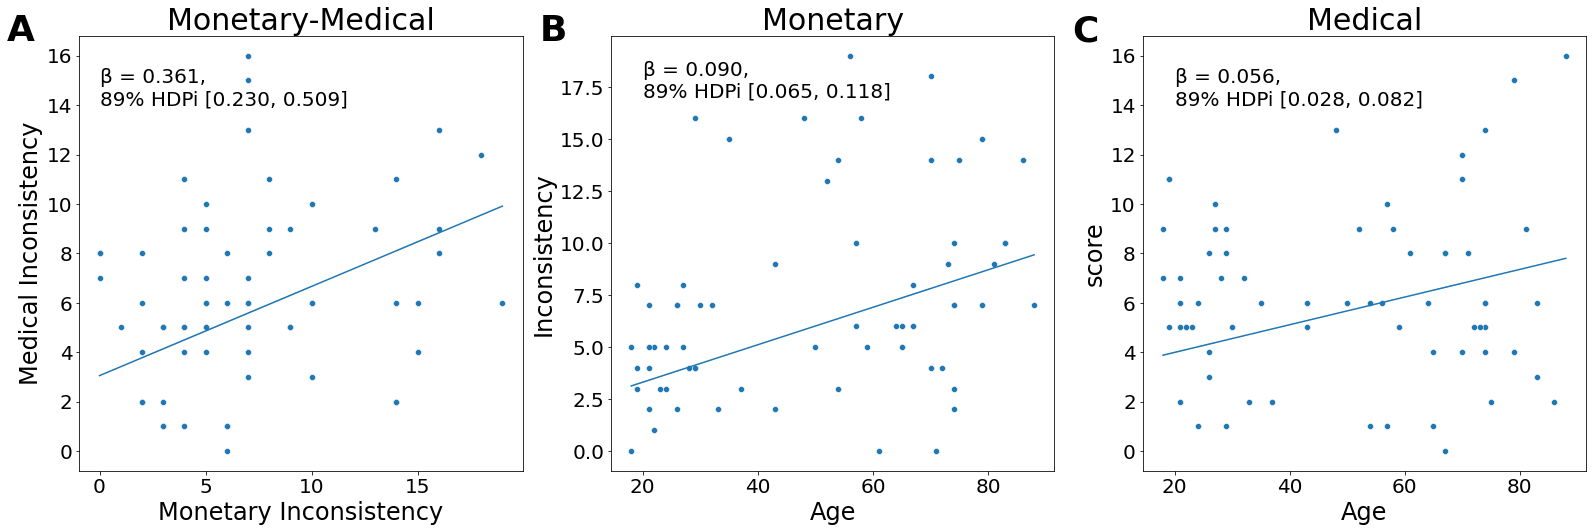

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(27, 8))

# Scatter plots
sns.scatterplot(x=const.score, y=const_med.score,                 ax=axes[0])
sns.scatterplot(x='age',       y='score',         data=const,     ax=axes[1])
sns.scatterplot(x='age',       y='score',         data=const_med, ax=axes[2])

# Line plots
sns.lineplot(x=const.score, 
             y=incmon_med['mean']['intercept'] + incmon_med['mean']['slope'] * const.score, 
             ax=axes[0])
sns.lineplot(x=const.age, 
             y=incMon['mean']['intercept']     + incMon['mean']['slope']     * const.age, 
             ax=axes[1])
sns.lineplot(x=const_med.age, 
             y=incMed['mean']['intercept']     + incMed['mean']['slope']     * const_med.age, 
             ax=axes[2])

# Set titles, labels, and adjust font sizes
axes[0].set(xlabel='Monetary Inconsistency', ylabel='Medical Inconsistency', title='Monetary-Medical')
axes[1].set(xlabel='Age', ylabel='Inconsistency', title='Monetary')
axes[2].set(xlabel='Age', title='Medical')

# Adjust font sizes for titles, axis labels, and tick labels
for ax in axes:
    ax.title.set_size(30)
    ax.xaxis.label.set_size(24)
    ax.yaxis.label.set_size(24)
    ax.tick_params(axis='both', which='major', labelsize=20)

# Adding subplot labels (A-C)
subplot_labels = ['A', 'B', 'C']
for ax, label in zip(axes, subplot_labels):
    ax.text(-0.1, 1.05, label, transform=ax.transAxes, fontsize=36, fontweight='bold', va='top', ha='right')

# Adding regression coefficients text with adjusted font size
text = 'β = {:.3f},\n89% HDPi [{:.3f}, {:.3f}]'.format(float(incmon_med['mean']['slope']),
                                                       float(incmon_med['hdi_5.5%']['slope']),
                                                       float(incmon_med['hdi_94.5%']['slope']))
axes[0].text(0, 14, text, fontsize=20) 

text = 'β = {:.3f},\n89% HDPi [{:.3f}, {:.3f}]'.format(float(incMon['mean']['slope']),
                                                       float(incMon['hdi_5.5%']['slope']),
                                                       float(incMon['hdi_94.5%']['slope']))
axes[1].text(20, 17, text, fontsize=20)

text = 'β = {:.3f},\n89% HDPi [{:.3f}, {:.3f}]'.format(float(incMed['mean']['slope']),
                                                       float(incMed['hdi_5.5%']['slope']),
                                                       float(incMed['hdi_94.5%']['slope']))
axes[2].text(20, 14, text, fontsize=20)



plt.show()